In [1]:
import os
import json
from PIL import Image, ImageFont, ImageDraw
import cv2

import json
import shutil
from tqdm.auto import tqdm

from ultralytics import YOLO
import torch

train_dir = './train'

WARNING  Known issue with torch>=2.4.0 on Windows with CPU, recommend downgrading to torch<=2.3.1 to resolve https://github.com/ultralytics/ultralytics/issues/15049


width, height:  (260, 1262)
mode: RGB


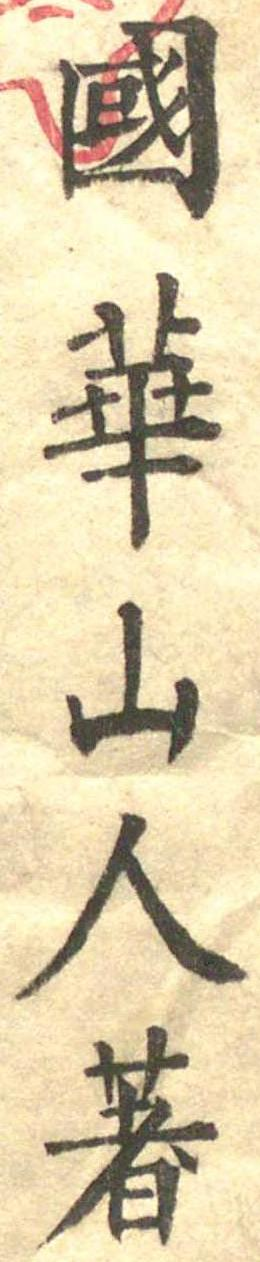

In [2]:
img_path = os.path.join(train_dir, '00000.jpg')
img = Image.open(img_path)
print('width, height: ', img.size)
print('mode:', img.mode)
img

In [3]:
annotation_path = os.path.join(train_dir, '00000.json')
with open(annotation_path, encoding='utf-8') as f:
    ann = json.load(f)

国華山人著


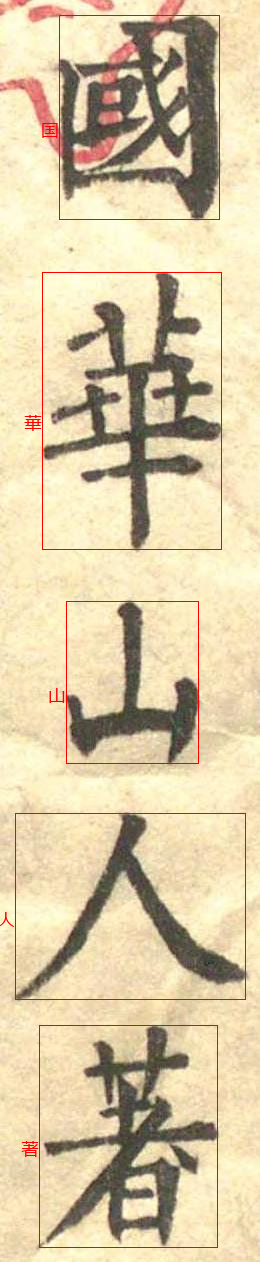

In [4]:
def vis_annotation(img, ann, font_path, font_size):
    font = ImageFont.truetype(font_path, font_size)     # PILでフォントを定義
    draw = ImageDraw.Draw(img)
    for label in ann['labels']:
        draw.text(xy=(label['bbox'][0]-font_size, int((label['bbox'][1]+label['bbox'][3])/2)), text=label['label'], font=font, fill=(255,0,0))
        draw.line((label['bbox'][0], label['bbox'][1], label['bbox'][2], label['bbox'][1]), fill=(255, 0, 0), width=1)
        draw.line((label['bbox'][2], label['bbox'][1], label['bbox'][2], label['bbox'][3]), fill=(255, 0, 0), width=1)
        draw.line((label['bbox'][2], label['bbox'][3], label['bbox'][0], label['bbox'][3]), fill=(255, 0, 0), width=1)
        draw.line((label['bbox'][0], label['bbox'][3], label['bbox'][0], label['bbox'][1]), fill=(255, 0, 0), width=1)
    print(ann['text'])
    return img
font_path = './meiryo.ttc'                          # フォントファイルへのパス
font_size = 18                                      # フォントサイズの指定
img = vis_annotation(img, ann, font_path, font_size)
img

In [5]:
img = cv2.imread("./train/00000.jpg")
print(img.shape)

(1262, 260, 3)


In [6]:
def convert_coordinates(image_width, image_height, x1, y1, x2, y2):
    # 座標を画像の幅と高さに対する相対的な座標に変換
    center_x = (x1 + x2) / (2.0 * image_width)
    center_y = (y1 + y2) / (2.0 * image_height)
    width = (x2 - x1) / image_width
    height = (y2 - y1) / image_height
    
    return center_x, center_y, width, height

def create_yolo_annotation(class_id, image_width, image_height, x1, y1, x2, y2):
    # YOLOの形式に座標を変換
    center_x, center_y, width, height = convert_coordinates(image_width, image_height, x1, y1, x2, y2)
    
    # YOLOのアノテーション形式の文字列を返す
    yolo_annotation = f"{class_id} {center_x} {center_y} {width} {height}"
    
    return yolo_annotation

def save_annotations_to_file(annotations, filename):
    with open(filename, 'w') as file:
        for annotation in annotations:
            file.write(annotation + '\n')

# 例として座標を変換してみる
class_id = 0  # クラスID
image_width = 640  # 画像の幅
image_height = 480  # 画像の高さ
x1, y1, x2, y2 = 100, 50, 500, 400  # 左上と右下の座標

yolo_annotation = create_yolo_annotation(class_id, image_width, image_height, x1, y1, x2, y2)
print(yolo_annotation)

0 0.46875 0.46875 0.625 0.7291666666666666


In [7]:
def make_data(src_img_dir, dst_img_dir, book_id_list):
    print('\n'+src_img_dir)
    count = 0
    character_labels = set()
    for fname in tqdm(os.listdir(src_img_dir)):
        sname, ext = os.path.splitext(fname)
        if ext=='.json':
            img_path = fname.split(".")[0]+".jpg"
            img = cv2.imread("./train/" + img_path)
            with open(os.path.join(src_img_dir, fname), encoding="utf-8") as f:
                ann = json.load(f)
                
            #print(ann["labels"][1])
            annotations = []
            for label in ann["labels"]:
                class_id = 0  # クラスID
                image_width = img.shape[1]  # 画像の幅
                image_height = img.shape[0]  # 画像の高さ
                x1, y1, x2, y2 = label["bbox"][0],label["bbox"][1],label["bbox"][2],label["bbox"][3]  # 左上と右下の座標

                yolo_annotation = create_yolo_annotation(class_id, image_width, image_height, x1, y1, x2, y2)
                #print(yolo_annotation)
                annotations.append(yolo_annotation)
            #print(annotations)


            if ann['book_id'] in book_id_list:
                #shutil.copy(os.path.join(src_img_dir, fname), os.path.join(dst_img_dir, fname))
                #shutil.copy(os.path.join(src_img_dir, sname+'.jpg'), os.path.join(dst_img_dir, sname+'.jpg'))
                for w in ann['text']:
                    character_labels.add(w)
                count+=1
                
            save_annotations_to_file(annotations, "./train_data_yolo/"+fname.split(".")[0]+'.txt')

In [8]:
dst_img_dir = './train_data_yolo'
os.makedirs(dst_img_dir, exist_ok=True)
book_id_list=[str(_).zfill(5) for _ in range(10)]
make_data(train_dir, './train_data_yolo', book_id_list)


./train


  0%|          | 0/22 [00:00<?, ?it/s]

In [9]:
from glob import glob
import pandas as pd
df_img = pd.DataFrame(glob("train/*.jpg"))
df_label = pd.DataFrame(glob("train_data_yolo/*"))
df = pd.concat([df_img,df_label],axis=1)
df.columns = ["img","label"]
df

,img,label
0,train\00000.jpg,train_data_yolo\00000.txt
1,train\00001.jpg,train_data_yolo\00001.txt
2,train\00002.jpg,train_data_yolo\00002.txt
3,train\00003.jpg,train_data_yolo\00003.txt
4,train\00004.jpg,train_data_yolo\00004.txt
5,train\00005.jpg,train_data_yolo\00005.txt
6,train\00006.jpg,train_data_yolo\00006.txt
7,train\00007.jpg,train_data_yolo\00007.txt
8,train\00008.jpg,train_data_yolo\00008.txt
9,train\00009.jpg,train_data_yolo\00009.txt


In [10]:
from sklearn.model_selection import train_test_split
train_df, valid_df = train_test_split(df, shuffle=True, random_state=0)
valid_df, test_df = train_test_split(valid_df, shuffle=True, random_state=0)

In [11]:
for path in train_df.values:
    shutil.copy(path[0], "./yolodatasets/train/images/"+path[0].split("\\")[1])
    shutil.copy(path[1], "./yolodatasets/train/labels/"+path[1].split("\\")[1])

for path in valid_df.values:
    shutil.copy(path[0], "./yolodatasets/valid/images/"+path[0].split("\\")[1])
    shutil.copy(path[1], "./yolodatasets/valid/labels/"+path[1].split("\\")[1])

for path in test_df.values:
    shutil.copy(path[0], "./yolodatasets/test/images/"+path[0].split("\\")[1])
    shutil.copy(path[1], "./yolodatasets/test/labels/"+path[1].split("\\")[1])

In [12]:
# Load a model
model = YOLO('model/yolov8n.pt')  # load a pretrained model (recommended for training)

# Train the model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
results = model.train(data=r"yolodatasets/data.yaml", epochs=10, imgsz=640, batch=24, device=0)

# Export the model
model.export(format="torchscript")

Ultralytics YOLOv8.2.87  Python-3.11.6 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
engine\trainer: task=detect, mode=train, model=model/yolov8n.pt, data=yolodatasets/data.yaml, epochs=10, time=None, patience=100, batch=24, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train29, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_co

train: Scanning C:\Users\ctiha\Desktop\git upload\2023_worldAI_YAMAGUCHI\yolodatasets\train\labels.cache... 8 images, 0
val: Scanning C:\Users\ctiha\Desktop\git upload\2023_worldAI_YAMAGUCHI\yolodatasets\valid\labels.cache... 2 images, 0 b


Plotting labels to C:\Users\ctiha\runs\detect\train29\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005625000000000001), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to C:\Users\ctiha\runs\detect\train29
Starting training for 10 epochs...
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      1.16G      3.182      4.089      2.061        118        640: 100%|██████████| 1/1 [00:04<00:00,  4.57
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          2         20      0.005       0.15    0.00766    0.00383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      1.12G      2.492      3.757      1.656        109        640: 100%|██████████| 1/1 [00:00<00:00,  4.11
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          2         20      0.005       0.15    0.00565    0.00231



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      1.12G      3.086      4.137       2.04        120        640: 100%|██████████| 1/1 [00:00<00:00,  3.84
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          2         20      0.005       0.15    0.00605    0.00244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      1.12G      2.875      3.887      1.987        117        640: 100%|██████████| 1/1 [00:00<00:00,  3.84
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          2         20      0.005       0.15    0.00523    0.00183



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      1.12G      2.574      3.817      1.754        108        640: 100%|██████████| 1/1 [00:00<00:00,  4.09
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          2         20      0.005       0.15    0.00465    0.00155



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      1.12G      2.921      4.085      1.995        111        640: 100%|██████████| 1/1 [00:00<00:00,  4.05
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          2         20      0.005       0.15    0.00437    0.00145



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      1.13G      2.674      3.853      1.753        114        640: 100%|██████████| 1/1 [00:00<00:00,  3.45
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          2         20      0.005       0.15    0.00502    0.00177



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      1.14G      2.896      3.868       1.95        117        640: 100%|██████████| 1/1 [00:00<00:00,  3.75
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          2         20      0.005       0.15    0.00965     0.0025



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      1.14G      2.891      3.752      1.969        115        640: 100%|██████████| 1/1 [00:00<00:00,  3.49
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          2         20      0.005       0.15    0.00838    0.00248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      1.14G      2.587      3.694      1.609        112        640: 100%|██████████| 1/1 [00:00<00:00,  3.95
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0

                   all          2         20      0.005       0.15    0.00612    0.00193



10 epochs completed in 0.005 hours.
Optimizer stripped from C:\Users\ctiha\runs\detect\train29\weights\last.pt, 6.2MB
Optimizer stripped from C:\Users\ctiha\runs\detect\train29\weights\best.pt, 6.2MB

Validating C:\Users\ctiha\runs\detect\train29\weights\best.pt...
Ultralytics YOLOv8.2.87  Python-3.11.6 torch-2.4.1+cu124 CUDA:0 (NVIDIA GeForce RTX 3060, 12288MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<0


                   all          2         20      0.005       0.15    0.00764    0.00382
Speed: 0.2ms preprocess, 11.4ms inference, 0.0ms loss, 2.3ms postprocess per image
Results saved to C:\Users\ctiha\runs\detect\train29
Ultralytics YOLOv8.2.87  Python-3.11.6 torch-2.4.1+cu124 CPU (AMD Ryzen 5 5600X 6-Core Processor)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

PyTorch: starting from 'C:\Users\ctiha\runs\detect\train29\weights\best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.9 MB)

TorchScript: starting export with torch 2.4.1+cu124...
TorchScript: export success  1.4s, saved as 'C:\Users\ctiha\runs\detect\train29\weights\best.torchscript' (11.9 MB)

Export complete (3.1s)
Results saved to C:\Users\ctiha\runs\detect\train29\weights
Predict:         yolo predict task=detect model=C:\Users\ctiha\runs\detect\train29\weights\best.torchscript imgsz=640  
Validate:        yolo val task=detect model=C:\Users\ctiha\runs

'C:\\Users\\ctiha\\runs\\detect\\train29\\weights\\best.torchscript'

In [13]:
from PIL import Image
from ultralytics import YOLO

# Load a pretrained YOLOv8n model
model = YOLO('best.pt')

# Run inference on 'bus.jpg'
results = model('yolodatasets/test/images/00002.jpg')  # results list

# Show the results
for r in results:
    im_array = r.plot()  # plot a BGR numpy array of predictions
    im = Image.fromarray(im_array[..., ::-1])  # RGB PIL image
    im.show()  # show image
    im.save('results.jpg')  # save image

FileNotFoundError: [Errno 2] No such file or directory: 'best.pt'